# Importación de librerías

In [2]:
import pandas as pd
import numpy as np

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [4]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

# Dataset CSV con metadatos generados a partir de los audios
dataset_urbansound8k_vfinal_path_file = "../../data/final/dataset_urbansound8k_vfinal.csv"

variable_predict =  'classID'

dataset_urbansound8k_df = pd.read_csv(dataset_urbansound8k_vfinal_path_file, sep=";")

dataset_urbansound8k_df.head(3)

,classID,tasa_cruce_cero,entropia_espectograma,avg_centroide_espectral,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,3,1947,6.716659,2503.702337,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,9.992785,4.795411,15.461894,-0.069880,-2.842674
1,2,27607,9.991457,2339.221804,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,7.720082,-6.460391,16.995657,-6.625116,1.469779
2,2,20971,9.728703,2070.826863,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,9.613501,-7.113610,16.179823,-5.710522,-0.899251


In [5]:
dataset_urbansound8k_df.columns

Index(['classID', 'tasa_cruce_cero', 'entropia_espectograma',
       'avg_centroide_espectral', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13'],
      dtype='object')

In [6]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas = ['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
             'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']

X = dataset_urbansound8k_df[columnas_caracteristicas]  # Características
y = dataset_urbansound8k_df[variable_predict]  # Variable objetivo

#  Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dataset_train_df = pd.DataFrame(X_train) 
dataset_train_df[variable_predict] = y_train
dataset_train_df.reset_index(drop=True, inplace=True)
dataset_train_df.head(3)

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,classID
0,-159.67445,181.50089,-92.606600,-15.836291,-32.712960,-0.886196,-2.333837,21.515417,25.863836,-0.396893,-0.778924,9.013906,6.754499,8
1,-219.52864,177.02522,-32.444240,26.932178,-21.066864,4.041955,-10.886847,-7.922688,-13.082119,-10.993799,-3.332730,-5.833699,-5.191674,9
2,-320.74875,205.43745,-47.278393,-87.469260,-26.390732,-40.026196,-48.005367,16.560823,49.147522,14.839294,-4.111610,4.170245,1.705174,8


# Modelos de Clasificacion

## KNeighborsClassifier

### Cross Validation - KNN

In [7]:
scaler = MinMaxScaler()

def determinar_best_model_knn(train_knn, variable_predict, flag_normalizar=0):
  
  print(" KNN evaluación con cross validation")
  print(" --------- ")
  print(f" Variable a predecir : {variable_predict} ")
  if flag_normalizar == 1:
    print(" Datos a normalizar : activado ")
  
  cv = KFold(n_splits = 11, shuffle=True, random_state=42) # Configurar el KFold
  plt.figure(figsize=(8, 5))  
  
  for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []

    for n_neighbors in range(1,30):
      fold_accuracy = []
      knn = KNeighborsClassifier(n_neighbors, weights=weights)
      
      # Verificar cada uno de los modelos con validación cruzada.
      for train_fold, test_fold in cv.split(train_knn):
                    
        # División train test aleatoria
        f_train = train_knn.loc[train_fold]
        f_test = train_knn.loc[test_fold]

        # Condicion para normalizar los datos
        if flag_normalizar == 1:
          norm_f_train_df = scaler.fit_transform(f_train.drop([variable_predict], axis=1))
          norm_f_test_df = scaler.fit_transform(f_test.drop([variable_predict], axis=1))
        else:
          norm_f_train_df = f_train.drop([variable_predict], axis=1)
          norm_f_test_df = f_test.drop([variable_predict], axis=1)

        # Entrenamiento y ejecución del modelo
        knn.fit( X = norm_f_train_df, y = f_train[variable_predict])
        y_pred = knn.predict(X = norm_f_test_df)

        # Evaluación del modelo
        acc = accuracy_score(f_test[variable_predict], y_pred)
        fold_accuracy.append(acc)

      # Calculo promedio de la accuracy
      total_scores.append(sum(fold_accuracy)/len(fold_accuracy))  

    plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
    print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('ACC') 

  plt.grid()
  plt.legend()
  plt.show()

 KNN evaluación con cross validation
 --------- 
 Variable a predecir : classID 


Max Value uniform : 0.8873299928418039 (1)
Max Value distance : 0.8873299928418039 (1)


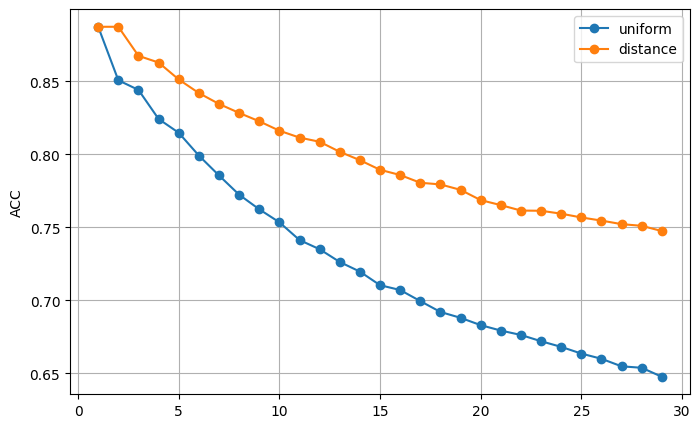

In [8]:
determinar_best_model_knn(dataset_train_df, variable_predict, flag_normalizar=0)

### GridSearchCV - KNN

In [9]:
# Definir el modelo KNN
knn = KNeighborsClassifier()

# Definir la rejilla de parámetros a buscar
param_grid = {
    'n_neighbors': [ 2, 3, 4, 5, 6, 7, 8, 9],       # Número de vecinos
    'weights': ['uniform', 'distance'], # Tipo de ponderación
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métricas de distancia
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores Parámetros: {best_params}")
print(f"Mejor Score: {best_score}")

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en conjunto de prueba: {accuracy}")

Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
Mejor Score: 0.8953471725125268
Accuracy en conjunto de prueba: 0.9061247853463079


### Modelo final

In [10]:
# Crear el modelo KNN
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan')

# Entrenar el modelo
knn.fit(X_train, y_train)

# Realizar predicciones
knn_y_pred = knn.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, knn_y_pred))
print("Classification Report:\n", classification_report(y_test, knn_y_pred))

Accuracy: 0.9061247853463079
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       203
           1       0.84      0.77      0.80        86
           2       0.89      0.90      0.89       183
           3       0.92      0.88      0.90       201
           4       0.92      0.89      0.91       206
           5       0.93      0.97      0.95       193
           6       0.74      0.89      0.81        72
           7       0.93      0.96      0.95       208
           8       0.93      0.95      0.94       165
           9       0.89      0.85      0.87       230

    accuracy                           0.91      1747
   macro avg       0.89      0.90      0.89      1747
weighted avg       0.91      0.91      0.91      1747



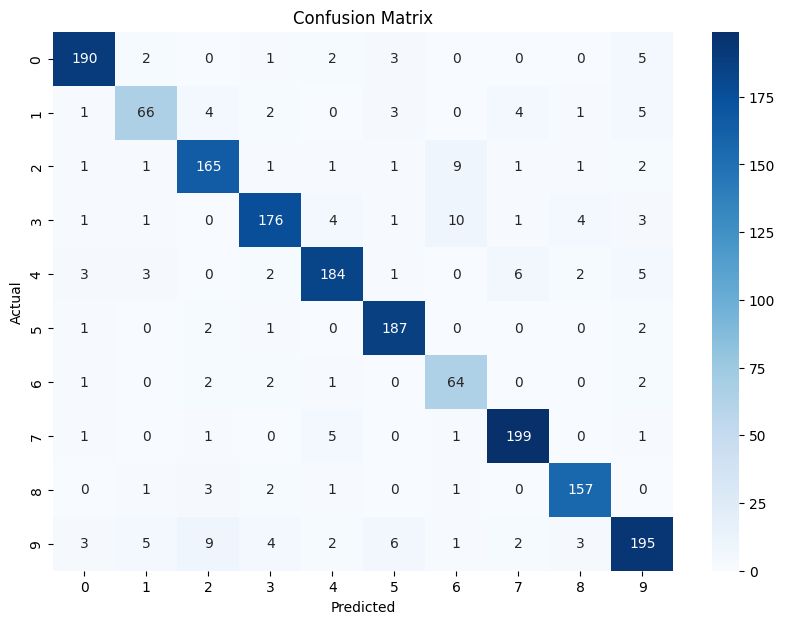

In [11]:
cm = confusion_matrix(y_test, knn_y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## SVM

### Cross Validation - SVM

In [9]:
scaler = MinMaxScaler()

def determinar_best_model_svm(train_svm, variable_predict, flag_normalizar=0):
  
    print("SVM evaluación con cross validation")
    print("---------")
    print(f"Variable a predecir : {variable_predict}")
    if flag_normalizar == 1:
        print("Datos a normalizar : activado")
    
    cv = KFold(n_splits=11, shuffle=True, random_state=42)  # Configurar el KFold
    plt.figure(figsize=(8, 5))
    
    for kernel in ['linear', 'rbf', 'poly']:  # Tipos de kernel que se probarán
        total_scores = []
        print(f"> kernel {kernel}")
        c_regulizacion_list = [0.000001] # [0.1, 1, 10, 100, 1000]: 

        for C in c_regulizacion_list: # Regularización en un rango logarítmico
            fold_accuracy = []
            svm = SVC(kernel=kernel, C=C)
            print(f">> C {C}")
            
            # Verificar cada uno de los modelos con validación cruzada
            for train_fold, test_fold in cv.split(train_svm):
                        
                # División train test aleatoria
                f_train = train_svm.loc[train_fold]
                f_test = train_svm.loc[test_fold]

                # Condición para normalizar los datos
                if flag_normalizar == 1:
                    norm_f_train_df = scaler.fit_transform(f_train.drop([variable_predict], axis=1))
                    norm_f_test_df = scaler.fit_transform(f_test.drop([variable_predict], axis=1))
                else:
                    norm_f_train_df = f_train.drop([variable_predict], axis=1)
                    norm_f_test_df = f_test.drop([variable_predict], axis=1)

                # Entrenamiento y ejecución del modelo
                svm.fit(X=norm_f_train_df, y=f_train[variable_predict])
                y_pred = svm.predict(X=norm_f_test_df)

                # Evaluación del modelo
                acc = accuracy_score(f_test[variable_predict], y_pred)
                fold_accuracy.append(acc)

            # Cálculo promedio de la accuracy
            total_scores.append(sum(fold_accuracy)/len(fold_accuracy))  

        plt.plot(c_regulizacion_list, total_scores, marker='o', label=kernel)
        print('Max Value ' + kernel + " : " + str(max(total_scores)) + " (C=" + str(c_regulizacion_list[np.argmax(total_scores)]) + ")")
        plt.ylabel('ACC') 

    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.show()


SVM evaluación con cross validation
---------
Variable a predecir : classID
> kernel linear
>> C 1e-06
Max Value linear : 0.35748031496062993 (C=1e-06)
> kernel rbf
>> C 1e-06
Max Value rbf : 0.11567644953471726 (C=1e-06)
> kernel poly
>> C 1e-06
Max Value poly : 0.11267000715819613 (C=1e-06)


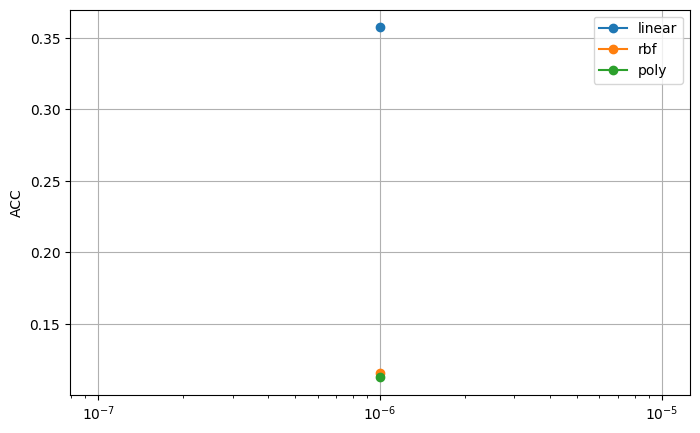

In [10]:
determinar_best_model_svm(dataset_train_df, variable_predict, flag_normalizar=0)

### GridSearchCV - SVM

In [10]:
# Definir el modelo SVM
svm = SVC()

# Definir la rejilla de parámetros a buscar
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], # Parámetro de regularización
    'kernel': ['linear', 'rbf', 'poly'], # Tipo de kernel
    'gamma': ['scale', 'auto'],          # Coeficiente del kernel para 'rbf' y 'poly'
    'degree': [2, 3, 4],                 # Grado del polinomio para 'poly'
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores Parámetros: {best_params}")
print(f"Mejor Score: {best_score}")

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en conjunto de prueba: {accuracy}")

KeyboardInterrupt: 

### Modelo final

In [7]:
# Crear el modelo KNN
svc = SVC(kernel='rbf', C=10)

# Entrenar el modelo
svc.fit(X_train, y_train)

# Realizar predicciones
svc_y_pred = svc.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, svc_y_pred))
print("Classification Report:\n", classification_report(y_test, svc_y_pred))

Accuracy: 0.6222095020034345
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.64      0.57       203
           1       0.64      0.40      0.49        86
           2       0.55      0.62      0.58       183
           3       0.66      0.74      0.70       201
           4       0.68      0.57      0.62       206
           5       0.69      0.62      0.65       193
           6       0.96      0.31      0.46        72
           7       0.64      0.83      0.72       208
           8       0.78      0.76      0.77       165
           9       0.49      0.46      0.48       230

    accuracy                           0.62      1747
   macro avg       0.66      0.59      0.60      1747
weighted avg       0.64      0.62      0.62      1747



## GMM

### GridSearchCV - GMM

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Definir el modelo GMM
gmm = GaussianMixture()

# Definir la rejilla de hiperparámetros a buscar
param_grid = {
    'n_components': [1, 2, 4, 8, 16],  # Número de componentes gausianas
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de matriz de covarianza
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerancia para la convergencia
    'reg_covar': [1e-6, 1e-5, 1e-4],  # Regularización de la covarianza
    'max_iter': [100, 200, 300]  # Número máximo de iteraciones
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores Parámetros: {best_params}")
print(f"Mejor Score: {best_score}")

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_gmm = grid_search.best_estimator_
y_pred = best_gmm.predict(X_test)

accuracy = accuracy_score(y_test, y


 GMM evaluación con cross validation
 --------- 
 Variable a predecir : classID 
 Datos a normalizar : activado 


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Max Value: 0.12208120574144442 (Componentes: 5)


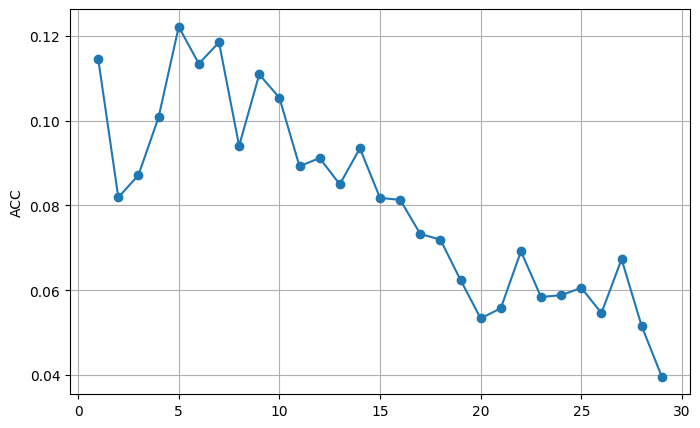

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def determinar_best_model_gmm(train_data, variable_predict, flag_normalizar=0):
    scaler = MinMaxScaler()

    print(" GMM evaluación con cross validation")
    print(" --------- ")
    print(f" Variable a predecir : {variable_predict} ")
    if flag_normalizar == 1:
        print(" Datos a normalizar : activado ")
  
    cv = KFold(n_splits=11, shuffle=True, random_state=42)  # Configurar el KFold
    plt.figure(figsize=(8, 5))  
  
    total_scores = []
    
    # Evaluar GMM con diferentes números de componentes
    for n_components in range(1, 30):
        fold_accuracy = []
        
        for train_fold, test_fold in cv.split(train_data):
            
            f_train = train_data.loc[train_fold]
            f_test = train_data.loc[test_fold]

            # Condición para normalizar los datos
            if flag_normalizar == 1:
                norm_f_train_df = scaler.fit_transform(f_train.drop([variable_predict], axis=1))
                norm_f_test_df = scaler.fit_transform(f_test.drop([variable_predict], axis=1))
            else:
                norm_f_train_df = f_train.drop([variable_predict], axis=1)
                norm_f_test_df = f_test.drop([variable_predict], axis=1)

            # Entrenamiento del modelo GMM
            gmm = GaussianMixture(n_components=n_components, random_state=42)
            gmm.fit(norm_f_train_df)
            
            # Obtener las predicciones (asignar cada muestra al componente más probable)
            y_pred = gmm.predict(norm_f_test_df)

            # Evaluación del modelo
            acc = accuracy_score(f_test[variable_predict], y_pred)
            fold_accuracy.append(acc)
        
        # Calcular promedio de la accuracy
        total_scores.append(sum(fold_accuracy)/len(fold_accuracy))  

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o')
    print('Max Value: ' + str(max(total_scores)) + " (Componentes: " + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('ACC') 

    plt.grid()
    plt.show()

# Ejemplo de uso
determinar_best_model_gmm(dataset_urbansound8k_df, 'classID', flag_normalizar=1)

In [12]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB

In [13]:
clf = GaussianNB()
clf.fit(X_train, y_train)
GMM_y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, GMM_y_pred)
print ('Acc', acc)

Acc 0.47395535203205497


In [17]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB

names = ["GaussianNB", "MultiNomialNB", 'BernouilliNB', 'ComplementNB']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()]

for name, clf in zip(names, classifiers):
  # FIT THE MODEL
  clf.fit(X_train, y_train)
  # PREDIT AND SCORE
  score = clf.score(X_test, y_test) #Returns the mean accuracy on the given test data and labels.

  GMM_y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, GMM_y_pred)
  print (f'{name} - Acc {acc}  | score {score}')

GaussianNB - Acc 0.46206699112510735  | score 0.46206699112510735
MultiNomialNB - Acc 0.3306613226452906  | score 0.3306613226452906
BernouilliNB - Acc 0.11022044088176353  | score 0.11022044088176353
ComplementNB - Acc 0.34554823933581447  | score 0.34554823933581447


## Random Forest

### GridSearchCV - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np


# Definir el modelo Random Forest
rf = RandomForestClassifier()

# Definir la rejilla de hiperparámetros a buscar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Máxima profundidad de cada árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en una hoja
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'bootstrap': [True, False]  # Método para seleccionar muestras para construir cada árbol
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores Parámetros: {best_params}")
print(f"Mejor Score: {best_score}")

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en conjunto de prueba: {accuracy}")


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def determinar_best_model_rf(train_data, variable_predict, flag_normalizar=0):
    scaler = MinMaxScaler()

    print(" Random Forest evaluación con cross validation")
    print(" --------- ")
    print(f" Variable a predecir : {variable_predict} ")
    if flag_normalizar == 1:
        print(" Datos a normalizar : activado ")
  
    cv = KFold(n_splits=11, shuffle=True, random_state=42)  # Configurar el KFold
    plt.figure(figsize=(8, 5))  
  
    total_scores = []
    
    # Evaluar Random Forest con diferentes números de estimadores
    for n_estimators in range(10, 201, 10):
        fold_accuracy = []
        
        for train_fold, test_fold in cv.split(train_data):
            
            f_train = train_data.loc[train_fold]
            f_test = train_data.loc[test_fold]

            # Condición para normalizar los datos
            if flag_normalizar == 1:
                norm_f_train_df = scaler.fit_transform(f_train.drop([variable_predict], axis=1))
                norm_f_test_df = scaler.transform(f_test.drop([variable_predict], axis=1))
            else:
                norm_f_train_df = f_train.drop([variable_predict], axis=1)
                norm_f_test_df = f_test.drop([variable_predict], axis=1)

            # Entrenamiento del modelo Random Forest
            rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
            rf.fit(norm_f_train_df, f_train[variable_predict])
            
            # Obtener las predicciones
            y_pred = rf.predict(norm_f_test_df)

            # Evaluación del modelo
            acc = accuracy_score(f_test[variable_predict], y_pred)
            fold_accuracy.append(acc)
        
        # Calcular promedio de la accuracy
        total_scores.append(sum(fold_accuracy) / len(fold_accuracy))  

    plt.plot(range(10, 201, 10), total_scores, marker='o')
    print('Max Value: ' + str(max(total_scores)) + " (Estimadores: " + str((np.argmax(total_scores) + 1) * 10) + ")")
    plt.xlabel('Número de Estimadores')
    plt.ylabel('ACC') 

    plt.grid()
    plt.show()

# Ejemplo de uso
determinar_best_model_rf(dataset_urbansound8k_df, 'classID', flag_normalizar=1)


 Random Forest evaluación con cross validation
 --------- 
 Variable a predecir : classID 
 Datos a normalizar : activado 
